In [1]:
import time
import pprint

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from typing import Dict, Text

plt.style.use('seaborn-whitegrid')

2022-04-21 05:55:55.800686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 05:55:55.800709: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Load Dataset

In [2]:
article_df = pd.read_csv('dataset/articles.csv')
customer_df = pd.read_csv('dataset/customers.csv')
trans_df = pd.read_csv('dataset/transactions_train.csv')

In [3]:
article_df.fillna(value='', inplace=True)

In [4]:
trans_df['t_dat'] = pd.to_datetime(trans_df['t_dat']).astype(int) / 10**9

/tmp/ipykernel_3021994/846968922.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  trans_df['t_dat'] = pd.to_datetime(trans_df['t_dat']).astype(int) / 10**9


In [5]:
trans_df.customer_id.values[0]

'000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318'

In [6]:
trans_df.rename(columns={"t_dat":"timestamp"}, inplace=True)

In [7]:
article_map = dict(article_df[['article_id', 'prod_name']].values)

In [8]:
trans_df['prod_name'] = trans_df.article_id.map(article_map)

In [74]:
articles = tf.data.Dataset.from_tensor_slices(dict(article_df)).map(lambda x: tf.strings.as_string(x['article_id']))

trans = tf.data.Dataset.from_tensor_slices(dict(trans_df[:1000000])).map(lambda x: {
    'customer_id' : x['customer_id'],
    'article_id' : tf.strings.as_string(x['article_id']),
    'prod_name' : x['prod_name'],
    'timestamp' : x['timestamp'],
})

### Preprocessing

In [10]:
timestamps = np.concatenate(list(trans.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

In [11]:
# ### USE THIS TO USE STRINGLOOKUP
# customer_vocab = tf.keras.layers.StringLookup(mask_token=None)
# customer_vocab.adapt(trans.map(lambda x: x["customer_id"]))

# article_vocab = tf.keras.layers.StringLookup(mask_token=None)
# article_vocab.adapt(articles)

In [12]:
### USE THIS TO AVOID STRINGLOOKUP
article_ids = articles.batch(1_000)
unique_article_ids = np.unique(np.concatenate(list(article_ids)))

customer_ids = trans.map(lambda x: x['customer_id']).batch(1_000)
unique_customer_ids = np.unique(np.concatenate(list(customer_ids)))

In [13]:
d = articles.batch(1_000)
len(list(d.as_numpy_iterator()))

106

## Two-tower Model

In [14]:
# ### USE THIS TO USE STRINGLOOKUP
# embedding_dim = 32

# customer_model = tf.keras.Sequential([
#     customer_vocab,
#     tf.keras.layers.Embedding(customer_vocab.vocabulary_size(), embedding_dim)
# ])
# article_model = tf.keras.Sequential([
#     article_vocab,
#     tf.keras.layers.Embedding(article_vocab.vocabulary_size(), embedding_dim)
# ])

# task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
#     articles.batch(128).map(article_model)
#   )
# )

In [15]:
# ### USE THIS TO AVOID STRINGLOOKUP
# embedding_dim = 32

# customer_model = tf.keras.Sequential([
#     tf.keras.layers.StringLookup(vocabulary=unique_customer_ids, mask_token=None),
#     tf.keras.layers.Embedding(len(unique_customer_ids)+1, embedding_dim)
# ])
# article_model = tf.keras.Sequential([
#     tf.keras.layers.StringLookup(vocabulary=unique_article_ids, mask_token=None),
#     tf.keras.layers.Embedding(len(unique_article_ids)+1, embedding_dim)
# ])

# task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
#     articles.batch(128).map(article_model)
#   )
# )

In [16]:
class CustomerModel(tf.keras.Model):
  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps
    
    embedding_dim = 32
    
    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_customer_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dim),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dim),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    print(input)
    if not self._use_timestamps:
      return self.user_embedding(inputs["customer_id"])

    return tf.concat([
        self.user_embedding(inputs["customer_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [17]:
class ArticleModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000
    
    embedding_dim = 32

    self.article_id_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_article_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dim)
    ])

#     self.article_vectorizer = tf.keras.layers.TextVectorization(
#         max_tokens=max_tokens)

#     self.article_text_embedding = tf.keras.Sequential([
#       self.article_vectorizer,
#       tf.keras.layers.Embedding(max_tokens, embedding_dim, mask_zero=True),
#       tf.keras.layers.GlobalAveragePooling1D(),
#     ])

#     self.article_vectorizer.adapt(articles.map(lambda x: x["prod_name"]))

  def call(self, inputs):
    return tf.concat([
        self.article_id_embedding(inputs),
#         self.article_text_embedding(inputs["prod_name"]),
    ], axis=1)

In [18]:
class HNMModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      CustomerModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      ArticleModel(),
      tf.keras.layers.Dense(32)
    ])

    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embedding = self.query_model({
        "customer_id": features["customer_id"],
        "timestamp": features["timestamp"],
    })
    candidate_embedding = self.candidate_model({
        "article_id": features["article_id"],
#         "prod_name": features["prod_name"],
    })

    return self.task(query_embedding, candidate_embedding)

## Model Training

In [75]:
shuffled = trans.shuffle(100_000, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [78]:
list(cached_train.as_numpy_iterator())[0]

{'customer_id': array([b'54f6d5274311ae719a4a8e7469ad5cd7a43dafc252f446332060b86c7df764d3',
        b'ffd9c246a42bdf42c6923238d0b5e66ba157ec68c5bcc61d89f24bb466d3cddc',
        b'1e6d960a176b9e4d9aed07387f7164845a2e2085f07f0d313602b4771b4ef4ae',
        ...,
        b'1e38c9a1b7cfbd093bf2719b0ff3406f57474e36dae8e471ec2a4af66675756a',
        b'934b876b64aeb1d5a24895d1dd2e857b927d38e7a9fa9ccae4d1c9997300bb12',
        b'a9db29ebfa809a9018169f65de70b0c515b174ac1f96ed2c7ce767eb96ea4efc'],
       dtype=object),
 'article_id': array([b'504152001', b'529012025', b'687427001', ..., b'355072003',
        b'384851013', b'656031001'], dtype=object),
 'prod_name': array([b'Friend', b'Hazelnut Brazilian Acacia Low',
        b'Brisbane off shoulder', ..., b'Anita Tank (1)', b'Sage Shorts',
        b'Eden Hipster Ch. Poppy Mid'], dtype=object),
 'timestamp': array([1.5374880e+09, 1.5374016e+09, 1.5374880e+09, ..., 1.5376608e+09,
        1.5376608e+09, 1.5374016e+09])}

In [68]:
ds = tf.data.Dataset.range(100)
ds = ds.shuffle(10)

tr = ds.take(8)
test = ds.skip(8).take(2)

c_tr = tr.shuffle(10)

In [69]:
list(c_tr.as_numpy_iterator())

[13, 6, 2, 7, 5, 4, 8, 14]

In [20]:
model = HNMModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model_def = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=100)

# train_accuracy = model.evaluate(
#     cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
# test_accuracy = model.evaluate(
#     cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

# print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
# print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/100
Consider rewriting this model with the Functional API.
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7fac9c42dac0>>
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7fac9c42dac0>>
Consider rewriting this model with the Functional API.
40/40 [==============================] - 115s 3s/step - factorized_top_k/top_1_categorical_accuracy: 9.7500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0069 - factorized_top_k/top_10_categorical_accuracy: 0.0114 - factorized_top_k/top_50_categorical_accuracy: 0.0296 - factorized_top_k/top_100_categorical_accuracy: 0.0441 - loss: 14852.3718 - regularization_loss: 0.0000e+00 - total_loss: 14852.3718
Epoch 2/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0083 - factorized_top_k/top_5_categorical_accuracy: 0

40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2504 - factorized_top_k/top_5_categorical_accuracy: 0.6896 - factorized_top_k/top_10_categorical_accuracy: 0.7980 - factorized_top_k/top_50_categorical_accuracy: 0.9273 - factorized_top_k/top_100_categorical_accuracy: 0.9526 - loss: 3243.4138 - regularization_loss: 0.0000e+00 - total_loss: 3243.4138
Epoch 13/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2531 - factorized_top_k/top_5_categorical_accuracy: 0.7045 - factorized_top_k/top_10_categorical_accuracy: 0.8140 - factorized_top_k/top_50_categorical_accuracy: 0.9351 - factorized_top_k/top_100_categorical_accuracy: 0.9587 - loss: 3128.8672 - regularization_loss: 0.0000e+00 - total_loss: 3128.8672
Epoch 14/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2558 - factorized_top_k/top_5_categorical_accuracy: 0.7135 - fa

40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2612 - factorized_top_k/top_5_categorical_accuracy: 0.8031 - factorized_top_k/top_10_categorical_accuracy: 0.9162 - factorized_top_k/top_50_categorical_accuracy: 0.9825 - factorized_top_k/top_100_categorical_accuracy: 0.9899 - loss: 2367.3844 - regularization_loss: 0.0000e+00 - total_loss: 2367.3844
Epoch 29/100
40/40 [==============================] - 117s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2596 - factorized_top_k/top_5_categorical_accuracy: 0.8066 - factorized_top_k/top_10_categorical_accuracy: 0.9195 - factorized_top_k/top_50_categorical_accuracy: 0.9834 - factorized_top_k/top_100_categorical_accuracy: 0.9908 - loss: 2339.7570 - regularization_loss: 0.0000e+00 - total_loss: 2339.7570
Epoch 30/100
40/40 [==============================] - 140s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2613 - factorized_top_k/top_5_categorical_accuracy: 0.8111 - fa

40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2531 - factorized_top_k/top_5_categorical_accuracy: 0.8389 - factorized_top_k/top_10_categorical_accuracy: 0.9484 - factorized_top_k/top_50_categorical_accuracy: 0.9924 - factorized_top_k/top_100_categorical_accuracy: 0.9962 - loss: 2107.2662 - regularization_loss: 0.0000e+00 - total_loss: 2107.2662
Epoch 45/100
40/40 [==============================] - 141s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2561 - factorized_top_k/top_5_categorical_accuracy: 0.8395 - factorized_top_k/top_10_categorical_accuracy: 0.9493 - factorized_top_k/top_50_categorical_accuracy: 0.9930 - factorized_top_k/top_100_categorical_accuracy: 0.9963 - loss: 2095.1410 - regularization_loss: 0.0000e+00 - total_loss: 2095.1410 - val_factorized_top_k/top_1_categorical_accuracy: 0.0238 - val_factorized_top_k/top_5_categorical_accuracy: 0.0750 - val_factorized_top_k/top_10_categorical_accuracy: 0.0870 - va

40/40 [==============================] - 142s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.2504 - factorized_top_k/top_5_categorical_accuracy: 0.8533 - factorized_top_k/top_10_categorical_accuracy: 0.9610 - factorized_top_k/top_50_categorical_accuracy: 0.9963 - factorized_top_k/top_100_categorical_accuracy: 0.9982 - loss: 1985.5686 - regularization_loss: 0.0000e+00 - total_loss: 1985.5686 - val_factorized_top_k/top_1_categorical_accuracy: 0.0236 - val_factorized_top_k/top_5_categorical_accuracy: 0.0765 - val_factorized_top_k/top_10_categorical_accuracy: 0.0886 - val_factorized_top_k/top_50_categorical_accuracy: 0.1153 - val_factorized_top_k/top_100_categorical_accuracy: 0.1329 - val_loss: 56181.2461 - val_regularization_loss: 0.0000e+00 - val_total_loss: 56181.2461
Epoch 61/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2497 - factorized_top_k/top_5_categorical_accuracy: 0.8535 - factorized_top_k/top_10_categorical

Epoch 76/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2455 - factorized_top_k/top_5_categorical_accuracy: 0.8601 - factorized_top_k/top_10_categorical_accuracy: 0.9671 - factorized_top_k/top_50_categorical_accuracy: 0.9980 - factorized_top_k/top_100_categorical_accuracy: 0.9989 - loss: 1897.9272 - regularization_loss: 0.0000e+00 - total_loss: 1897.9272
Epoch 77/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2456 - factorized_top_k/top_5_categorical_accuracy: 0.8603 - factorized_top_k/top_10_categorical_accuracy: 0.9674 - factorized_top_k/top_50_categorical_accuracy: 0.9980 - factorized_top_k/top_100_categorical_accuracy: 0.9989 - loss: 1891.3040 - regularization_loss: 0.0000e+00 - total_loss: 1891.3040
Epoch 78/100
40/40 [==============================] - 113s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2453 - factorized_top_k/top_5_categorical_accuracy

40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2415 - factorized_top_k/top_5_categorical_accuracy: 0.8637 - factorized_top_k/top_10_categorical_accuracy: 0.9709 - factorized_top_k/top_50_categorical_accuracy: 0.9987 - factorized_top_k/top_100_categorical_accuracy: 0.9993 - loss: 1847.0629 - regularization_loss: 0.0000e+00 - total_loss: 1847.0629
Epoch 93/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2423 - factorized_top_k/top_5_categorical_accuracy: 0.8635 - factorized_top_k/top_10_categorical_accuracy: 0.9712 - factorized_top_k/top_50_categorical_accuracy: 0.9987 - factorized_top_k/top_100_categorical_accuracy: 0.9994 - loss: 1845.7327 - regularization_loss: 0.0000e+00 - total_loss: 1845.7327
Epoch 94/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2406 - factorized_top_k/top_5_categorical_accuracy: 0.8655 - fa

In [21]:
model = HNMModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model_ts = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=100)

# train_accuracy = model.evaluate(
#     cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
# test_accuracy = model.evaluate(
#     cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

# print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
# print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/100
Consider rewriting this model with the Functional API.
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7fac9c42dac0>>
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7fac9c42dac0>>
Consider rewriting this model with the Functional API.
40/40 [==============================] - 113s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0044 - factorized_top_k/top_5_categorical_accuracy: 0.0104 - factorized_top_k/top_10_categorical_accuracy: 0.0148 - factorized_top_k/top_50_categorical_accuracy: 0.0355 - factorized_top_k/top_100_categorical_accuracy: 0.0517 - loss: 14850.3757 - regularization_loss: 0.0000e+00 - total_loss: 14850.3757
Epoch 2/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0055 - factorized_top_k/top_5_categorical_accuracy: 0.029

40/40 [==============================] - 113s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2466 - factorized_top_k/top_5_categorical_accuracy: 0.6820 - factorized_top_k/top_10_categorical_accuracy: 0.7886 - factorized_top_k/top_50_categorical_accuracy: 0.9177 - factorized_top_k/top_100_categorical_accuracy: 0.9462 - loss: 3323.3544 - regularization_loss: 0.0000e+00 - total_loss: 3323.3544
Epoch 13/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2496 - factorized_top_k/top_5_categorical_accuracy: 0.6953 - factorized_top_k/top_10_categorical_accuracy: 0.8054 - factorized_top_k/top_50_categorical_accuracy: 0.9273 - factorized_top_k/top_100_categorical_accuracy: 0.9528 - loss: 3211.0440 - regularization_loss: 0.0000e+00 - total_loss: 3211.0440
Epoch 14/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2501 - factorized_top_k/top_5_categorical_accuracy: 0.7074 - fa

40/40 [==============================] - 116s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2586 - factorized_top_k/top_5_categorical_accuracy: 0.8017 - factorized_top_k/top_10_categorical_accuracy: 0.9097 - factorized_top_k/top_50_categorical_accuracy: 0.9773 - factorized_top_k/top_100_categorical_accuracy: 0.9862 - loss: 2413.7881 - regularization_loss: 0.0000e+00 - total_loss: 2413.7881
Epoch 29/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2588 - factorized_top_k/top_5_categorical_accuracy: 0.8062 - factorized_top_k/top_10_categorical_accuracy: 0.9132 - factorized_top_k/top_50_categorical_accuracy: 0.9789 - factorized_top_k/top_100_categorical_accuracy: 0.9872 - loss: 2403.4073 - regularization_loss: 0.0000e+00 - total_loss: 2403.4073
Epoch 30/100
40/40 [==============================] - 143s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.2572 - factorized_top_k/top_5_categorical_accuracy: 0.8077 - fa

40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2540 - factorized_top_k/top_5_categorical_accuracy: 0.8405 - factorized_top_k/top_10_categorical_accuracy: 0.9447 - factorized_top_k/top_50_categorical_accuracy: 0.9898 - factorized_top_k/top_100_categorical_accuracy: 0.9940 - loss: 2136.6437 - regularization_loss: 0.0000e+00 - total_loss: 2136.6437
Epoch 45/100
40/40 [==============================] - 139s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2528 - factorized_top_k/top_5_categorical_accuracy: 0.8406 - factorized_top_k/top_10_categorical_accuracy: 0.9452 - factorized_top_k/top_50_categorical_accuracy: 0.9902 - factorized_top_k/top_100_categorical_accuracy: 0.9943 - loss: 2120.3709 - regularization_loss: 0.0000e+00 - total_loss: 2120.3709 - val_factorized_top_k/top_1_categorical_accuracy: 0.0210 - val_factorized_top_k/top_5_categorical_accuracy: 0.0708 - val_factorized_top_k/top_10_categorical_accuracy: 0.0838 - va

40/40 [==============================] - 139s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2514 - factorized_top_k/top_5_categorical_accuracy: 0.8553 - factorized_top_k/top_10_categorical_accuracy: 0.9577 - factorized_top_k/top_50_categorical_accuracy: 0.9944 - factorized_top_k/top_100_categorical_accuracy: 0.9968 - loss: 2000.0224 - regularization_loss: 0.0000e+00 - total_loss: 2000.0224 - val_factorized_top_k/top_1_categorical_accuracy: 0.0231 - val_factorized_top_k/top_5_categorical_accuracy: 0.0732 - val_factorized_top_k/top_10_categorical_accuracy: 0.0842 - val_factorized_top_k/top_50_categorical_accuracy: 0.1073 - val_factorized_top_k/top_100_categorical_accuracy: 0.1240 - val_loss: 61015.6172 - val_regularization_loss: 0.0000e+00 - val_total_loss: 61015.6172
Epoch 61/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2512 - factorized_top_k/top_5_categorical_accuracy: 0.8559 - factorized_top_k/top_10_categorical

Epoch 76/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2462 - factorized_top_k/top_5_categorical_accuracy: 0.8637 - factorized_top_k/top_10_categorical_accuracy: 0.9657 - factorized_top_k/top_50_categorical_accuracy: 0.9963 - factorized_top_k/top_100_categorical_accuracy: 0.9980 - loss: 1910.9074 - regularization_loss: 0.0000e+00 - total_loss: 1910.9074
Epoch 77/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2462 - factorized_top_k/top_5_categorical_accuracy: 0.8637 - factorized_top_k/top_10_categorical_accuracy: 0.9660 - factorized_top_k/top_50_categorical_accuracy: 0.9966 - factorized_top_k/top_100_categorical_accuracy: 0.9981 - loss: 1899.2411 - regularization_loss: 0.0000e+00 - total_loss: 1899.2411
Epoch 78/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2474 - factorized_top_k/top_5_categorical_accuracy

40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2452 - factorized_top_k/top_5_categorical_accuracy: 0.8690 - factorized_top_k/top_10_categorical_accuracy: 0.9700 - factorized_top_k/top_50_categorical_accuracy: 0.9975 - factorized_top_k/top_100_categorical_accuracy: 0.9989 - loss: 1851.4089 - regularization_loss: 0.0000e+00 - total_loss: 1851.4089
Epoch 93/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2460 - factorized_top_k/top_5_categorical_accuracy: 0.8692 - factorized_top_k/top_10_categorical_accuracy: 0.9703 - factorized_top_k/top_50_categorical_accuracy: 0.9976 - factorized_top_k/top_100_categorical_accuracy: 0.9990 - loss: 1853.3614 - regularization_loss: 0.0000e+00 - total_loss: 1853.3614
Epoch 94/100
40/40 [==============================] - 114s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.2457 - factorized_top_k/top_5_categorical_accuracy: 0.8684 - fa

In [22]:
# model = RecModel(customer_model, article_model, task)
# model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# model.fit(trans.batch(4096), epochs=3)

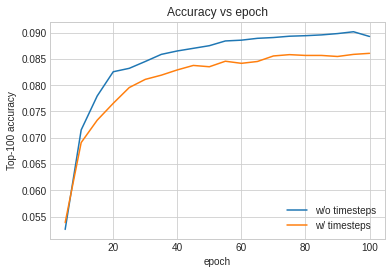

In [28]:
num_validation_runs = len(model_def.history["val_factorized_top_k/top_10_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model_def.history["val_factorized_top_k/top_10_categorical_accuracy"], label="w/o timesteps")
plt.plot(epochs, model_ts.history["val_factorized_top_k/top_10_categorical_accuracy"], label="w/ timesteps")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

## Get Recommendation

In [82]:
articles.batch(100)

<BatchDataset shapes: (None,), types: tf.string>

In [79]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)

# print(articles.batch(100).map(lambda title: (title, model.candidate_model(title))))

# index.index_from_dataset(
#     articles.batch(100).map(lambda title: (title, model.candidate_model(title))))

index.index_from_dataset(
    articles.batch(100).map(lambda x: model.candidate_model({
        'article_id': x['article_id'],
        'prod_name' : x['prod_name'],
    })))

# index.index(articles.batch(100).map(model.candidate_model),
#            articles.batch(100).map(lambda x: x['article_id']))

# model.candidate_model('')

test_query = dict(trans_df[['customer_id',
                           'timestamp',
                        ]].iloc[10].map(lambda x: tf.expand_dims(x, axis=0)))

_, titles = index(test_query, k=3)
print(f"Top 12 recommendations for user 40: {titles[0, :20]}")

TypeError: in user code:

    File "/tmp/ipykernel_3021994/2158798132.py", line 10, in None  *
        lambda x: model.candidate_model({

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'article_id'


In [73]:
article_map[501323011]

'Thomas paperbag wide'

In [26]:
trans_df.iloc[0].customer_id

'000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318'

In [27]:
trans_df[['customer_id','timestamp']].iloc[0]

customer_id    000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
timestamp                                           1537401600.0
Name: 0, dtype: object